In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import re

In [14]:
# Do this for 
# cohort = 'System'
# cohort = 'LiberalArts' and 
# cohort = 'Peers'
cohort = 'LiberalArts'
df = pd.read_csv(f'TeacherStudentIPEDS{cohort}.csv')
df

,UnitID,Institution Name,Sector of institution (HD2023),Instructional staff on 9 10 11 or 12 month contract-total (SAL2023_IS All full-time instructional staff total),Salary outlays - total (SAL2023_IS All full-time instructional staff total),Grand total (EF2023 All students Undergraduate total),Grand total (EF2023 All students Graduate and First professional),Instructional staff on 9 10 11 or 12 month contract-total (SAL2022_IS_RV All full-time instructional staff total),Salary outlays - total (SAL2022_IS_RV All full-time instructional staff total),Grand total (EF2022_RV All students Undergraduate total),...,Grand total (EF2014_RV All students Graduate and First professional),Instructional staff on 9 10 11 or 12 month contract-total (SAL2013_IS_RV All full-time instructional staff total),Salary outlays - total (SAL2013_IS_RV All full-time instructional staff total),Grand total (EF2013_RV All students Undergraduate total),Grand total (EF2013_RV All students Graduate and First professional),Instructional staff on 9 10 11 or 12 month contract-total (SAL2012_IS_RV All full-time instructional staff total),Salary outlays - total (SAL2012_IS_RV All full-time instructional staff total),Grand total (EF2012_RV All students Undergraduate total),Grand total (EF2012_RV All students Graduate and First professional),Unnamed: 51
0,138600,Agnes Scott College,2,95.0,8316594.0,911,166.0,93.0,8120960.0,1006,...,NaN,75.0,5655886.0,915.0,NaN,70.0,5090643.0,885.0,NaN,NaN
1,168546,Albion College,2,117.0,7768728.0,1354,NaN,123.0,8453738.0,1456,...,NaN,109.0,6836455.0,1307.0,NaN,114.0,6945806.0,1382.0,NaN,NaN
2,210571,Albright College,2,110.0,7403285.0,1328,324.0,114.0,7720044.0,1298,...,33.0,119.0,7671338.0,2349.0,35.0,118.0,7792905.0,2199.0,65.0,NaN
3,210669,Allegheny College,2,133.0,10116547.0,1231,NaN,140.0,10683343.0,1353,...,NaN,183.0,13353372.0,2161.0,NaN,168.0,12341496.0,2140.0,NaN,NaN
4,164465,Amherst College,2,282.0,36902852.0,1910,NaN,273.0,34510434.0,1898,...,NaN,219.0,23041640.0,1785.0,NaN,209.0,20899875.0,1817.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,210401,Willamette University,2,175.0,17189729.0,1571,541.0,163.0,16103223.0,1367,...,614.0,228.0,19168577.0,2119.0,736.0,250.0,20771351.0,2101.0,830.0,NaN
145,168342,Williams College,2,309.0,41461786.0,2112,56.0,308.0,40193882.0,2169,...,54.0,285.0,30886585.0,2096.0,54.0,290.0,30971087.0,2070.0,54.0,NaN
146,206525,Wittenberg University,2,97.0,6959872.0,1288,45.0,97.0,6840634.0,1258,...,16.0,131.0,8362413.0,1959.0,20.0,141.0,8835543.0,1881.0,13.0,NaN
147,218973,Wofford College,2,145.0,11734010.0,1873,NaN,150.0,11960717.0,1823,...,NaN,127.0,8992195.0,1615.0,NaN,124.0,8600274.0,1619.0,NaN,NaN


In [15]:
# Columns to preserve
id_cols = [
    'UnitID', 'Institution Name', 
    # 'Institution name alias (HD2023)', 
    'Sector of institution (HD2023)'
]

df_long = df.melt(id_vars=id_cols, var_name='column', value_name='cnt')
df_long = df_long.dropna(subset=['cnt'])
df_long = df_long[df_long['cnt'].astype(str).str.strip() != '']

def extract_year_variable(col):
    if match := re.search(r'(SAL|EF)(\d{4})', col):
        kind, year = match.groups()
        if "Instructional staff" in col:
            return int(year), "TeacherCnt"
        elif "Undergraduate total" in col:
            return int(year), "UndergraduateCnt"
        elif "Graduate and First professional" in col:
            return int(year), "GraduateCnt"
        elif "Salary" in col:
            return int(year), "SalaryOutlay"
    return None, None

df_long[['Year', 'Variable']] = df_long['column'].apply(lambda x: pd.Series(extract_year_variable(x)))
df_long = df_long.dropna(subset=['Year', 'Variable'])


# Pivot to tidy format
df_tidy = df_long.pivot_table(
    index=[
        'UnitID', 'Institution Name', 
        # 'Institution name alias (HD2023)', 
        'Sector of institution (HD2023)', 
        'Year'
    ],
    columns='Variable',
    values='cnt',
    aggfunc='first'
).reset_index()

# Rename columns
df_tidy.rename(columns={
    'UnitID': 'SchoolID',
    'Institution Name': 'SchoolName',
    # 'Institution name alias (HD2023)': 'SchoolAlias',
    'Sector of institution (HD2023)': 'Sector'
}, inplace=True)

# Convert count columns to numeric
for col in ['UndergraduateCnt', 'GraduateCnt', 'SalaryOutlay', 'TeacherCnt']:
    df_tidy[col] = pd.to_numeric(df_tidy[col], errors='coerce').fillna(0).apply(int)

df_tidy['Cohort'] = cohort
df_tidy

Variable,SchoolID,SchoolName,Sector,Year,GraduateCnt,SalaryOutlay,TeacherCnt,UndergraduateCnt,Cohort
0,101912,Oakwood University,2,2012,53,5881292,109,1966,LiberalArts
1,101912,Oakwood University,2,2013,42,5688651,103,1861,LiberalArts
2,101912,Oakwood University,2,2014,59,5713515,108,1880,LiberalArts
3,101912,Oakwood University,2,2015,46,4901061,92,1703,LiberalArts
4,101912,Oakwood University,2,2016,54,5285779,100,1740,LiberalArts
...,...,...,...,...,...,...,...,...,...
1780,446048,Ave Maria University,2,2019,48,4326096,63,1129,LiberalArts
1781,446048,Ave Maria University,2,2020,37,4252786,61,1071,LiberalArts
1782,446048,Ave Maria University,2,2021,43,4749494,63,1259,LiberalArts
1783,446048,Ave Maria University,2,2022,63,5213702,69,1247,LiberalArts


In [16]:
df_tidy.to_csv(f'{cohort}StudentsAndTeachers.csv', index=False)

In [19]:
dfPeers = pd.read_csv('PeersStudentsAndTeachers.csv')
dfSystem = pd.read_csv('SystemStudentsAndTeachers.csv')
dfLiberalArts = pd.read_csv('LiberalArtsStudentsAndTeachers.csv')
dfMerged = pd.concat([dfSystem, dfLiberalArts, dfPeers])
dfMerged

,SchoolID,SchoolName,Sector,Year,GraduateCnt,SalaryOutlay,TeacherCnt,UndergraduateCnt,Cohort
0,197869,Appalachian State University,1,2012,1877,62327615,901,15712,System
1,197869,Appalachian State University,1,2013,1813,62484822,901,16025,System
2,197869,Appalachian State University,1,2014,1771,63872066,920,16255,System
3,197869,Appalachian State University,1,2015,1642,65648607,930,16290,System
4,197869,Appalachian State University,1,2016,1700,71149902,951,16595,System
...,...,...,...,...,...,...,...,...,...
151,262129,New College of Florida,1,2019,24,8147741,105,702,Peers
152,262129,New College of Florida,1,2020,29,8368586,108,646,Peers
153,262129,New College of Florida,1,2021,27,7956314,103,632,Peers
154,262129,New College of Florida,1,2022,20,7802818,97,669,Peers


In [20]:
dfMerged.to_csv('StudentTeacherData.csv', index=False)

In [ ]:
# Columns to preserve
id_cols = [
    'UnitID', 'Institution Name', 
    # 'Institution name alias (HD2023)', 
    'Sector of institution (HD2023)'
]

df_long = df.melt(id_vars=id_cols, var_name='column', value_name='cnt')
df_long = df_long.dropna(subset=['cnt'])
df_long = df_long[df_long['cnt'].astype(str).str.strip() != '']

def extract_year_variable(col):
    if match := re.search(r'(SAL|EF)(\d{4})', col):
        kind, year = match.groups()
        if "Instructional staff" in col:
            return int(year), "TeacherCnt"
        elif "Undergraduate total" in col:
            return int(year), "UndergraduateCnt"
        elif "Graduate and First professional" in col:
            return int(year), "GraduateCnt"
    return None, None

df_long[['Year', 'Variable']] = df_long['column'].apply(lambda x: pd.Series(extract_year_variable(x)))
df_long = df_long.dropna(subset=['Year', 'Variable'])

# Pivot to tidy format
df_tidy = df_long.pivot_table(
    index=[
        'UnitID', 'Institution Name', 
        # 'Institution name alias (HD2023)', 
        'Sector of institution (HD2023)', 
        'Year'
    ],
    columns='Variable',
    values='cnt',
    aggfunc='first'
).reset_index()

# Rename columns
df_tidy.rename(columns={
    'UnitID': 'SchoolID',
    'Institution Name': 'SchoolName',
    # 'Institution name alias (HD2023)': 'SchoolAlias',
    'Sector of institution (HD2023)': 'Sector'
}, inplace=True)

# Convert count columns to numeric
for col in ['TeacherCnt', 'UndergraduateCnt', 'GraduateCnt']:
    df_tidy[col] = pd.to_numeric(df_tidy[col], errors='coerce').fillna(0)

# Compute ratios
df_tidy['StudentTeacherRatioOverall'] = (
    (df_tidy['UndergraduateCnt'] + df_tidy['GraduateCnt']) / df_tidy['TeacherCnt']
).replace([float('inf'), -float('inf')], pd.NA)

df_tidy['StudentTeacherRatioUndergraduate'] = (
    df_tidy['UndergraduateCnt'] / df_tidy['TeacherCnt']
).replace([float('inf'), -float('inf')], pd.NA)

# Compute RelativeChange
df_tidy.sort_values(by=['SchoolID', 'Year'], inplace=True)
ref_pop = df_tidy[df_tidy['Year'] == 2012].set_index('SchoolID')['UndergraduateCnt'] + \
          df_tidy[df_tidy['Year'] == 2012].set_index('SchoolID')['GraduateCnt']
df_tidy['ReferencePopulation'] = df_tidy['SchoolID'].map(ref_pop)
df_tidy['CurrentPopulation'] = df_tidy['UndergraduateCnt'] + df_tidy['GraduateCnt']
df_tidy['RelativeChange'] = df_tidy['CurrentPopulation'] / df_tidy['ReferencePopulation']
df_tidy.loc[df_tidy['Year'] == 2012, 'RelativeChange'] = 1.0
df_tidy.drop(columns=['ReferencePopulation', 'CurrentPopulation'], inplace=True)
df_tidy['Cohort'] = cohort

df_final = df_tidy[['SchoolID', 'SchoolName', #'SchoolAlias', 
    'Cohort', 'Sector', 'Year', 
    'TeacherCnt', 'UndergraduateCnt', 'GraduateCnt', 
    'StudentTeacherRatioOverall', 'StudentTeacherRatioUndergraduate', 'RelativeChange']]
df_final

In [ ]:
df_final.to_csv(f'{cohort}Data.csv', index=False)

In [ ]:
dfSystem = pd.read_csv('SystemData.csv')
dfLiberalArts = pd.read_csv('LiberalArtsData.csv')
dfMerged = pd.concat([dfSystem, dfLiberalArts])
dfMerged

In [ ]:
dfMerged.to_csv('MergedData.csv', index=False)

In [ ]:
df = pd.read_csv("TeacherStudentIPEDSLiberalArts.csv")

# Keep ID and Name columns
id_vars = [
    'UnitID', 'Institution Name', 
    # 'Institution name alias (HD2023)', 
    # 'State abbreviation (HD2023)', 
    'Sector of institution (HD2023)'
]

# All other columns are value columns
value_vars = [col for col in df.columns if col not in id_vars]

# Melt the dataframe to long format
df_long = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='column', value_name='cnt')

# Drop rows with missing or empty counts
df_long = df_long.dropna(subset=['cnt'])
df_long = df_long[df_long['cnt'].astype(str).str.strip() != '']

# Function to extract year and variable
def extract_year_variable(col_name):
    year_match = re.search(r'(19|20)\d{2}', col_name)
    year = int(year_match.group(0)) if year_match else None

    if 'Undergraduate' in col_name:
        variable = 'undergraduate_student_cnt'
    elif 'Graduate and First professional' in col_name:
        variable = 'graduate_student_cnt'
    elif ('instruction' in col_name):
        variable = 'teacher_cnt'
    else:
        variable = None  # We'll drop these

    return pd.Series({'year': year, 'variable': variable})

# Apply the extractor function
df_long = df_long.join(df_long['column'].apply(extract_year_variable))

# Drop rows without a recognized variable or year
df_clean = df_long.dropna(subset=['year', 'variable'])

# Rename for final output
df_clean = df_clean.rename(columns={
    'UnitID': 'SchoolID',
    'Institution Name': 'SchoolName',
    'Sector of institution (HD2023)': 'Sector'
})

# Keep only relevant columns
df_final = df_clean[['SchoolID', 'SchoolName', 'Sector', 'year', 'variable', 'cnt']]

df_final2 = df_final[(df_final.SchoolID != 433174) & (df_final.SchoolID != 199184)]
df_final2['cnt'] = df_final2['cnt'].apply(int)
df_final2['year'] = df_final2['year'].apply(int)

# df_final2.to_csv('system_schools.csv', index=False)


In [ ]:
# Pivot to get counts for ratio computation
df_wide = df_final2.pivot_table(
    index=['SchoolID', 'SchoolName', 'year'],
    columns='variable',
    values='cnt',
    aggfunc='first'
).reset_index()

# Fill missing values with 0
df_wide = df_wide.fillna(0)

# Compute ratios
df_wide['student_teacher_ratio'] = (
    (df_wide['undergraduate_student_cnt'] + df_wide['graduate_student_cnt']) / df_wide['teacher_cnt']
).replace([float('inf'), -float('inf')], None)

df_wide['ug_student_teacher_ratio'] = (
    df_wide['undergraduate_student_cnt'] / df_wide['teacher_cnt']
).replace([float('inf'), -float('inf')], None)

# Convert ratio columns to tidy format
ratio_long = df_wide.melt(
    id_vars=['SchoolID', 'SchoolName', 'year'],
    value_vars=['student_teacher_ratio', 'ug_student_teacher_ratio'],
    var_name='variable',
    value_name='cnt'
)

# Ensure cnt is numeric
ratio_long['cnt'] = ratio_long['cnt'].astype(float)

# Combine with original tidy data
df_tidy_with_ratios = pd.concat([df_final2, ratio_long], ignore_index=True)

# Save
df_tidy_with_ratios.to_csv("liberal_arts_schools.csv", index=False)


In [ ]:

# Columns to preserve directly
id_cols = [
    'UnitID', 
    'Institution Name', 
    'Institution name alias (HD2023)', 
    'Sector of institution (HD2023)'
]

# Melt the rest of the data into long format
df_long = df.melt(id_vars=id_cols, var_name='column', value_name='cnt')

# Drop empty or null rows
df_long = df_long.dropna(subset=['cnt'])
df_long = df_long[df_long['cnt'].astype(str).str.strip() != '']

# Extract year and variable type from the column name
def extract_year_variable(col):
    if match := re.search(r'(SAL|EF)(\d{4})', col):
        kind, year = match.groups()
        if "Instructional staff" in col:
            return int(year), "TeacherCnt"
        elif "Undergraduate total" in col:
            return int(year), "UndergraduateCnt"
        elif "Graduate and First professional" in col:
            return int(year), "GraduateCnt"
    return None, None

df_long[['Year', 'Variable']] = df_long['column'].apply(lambda x: pd.Series(extract_year_variable(x)))
df_long = df_long.dropna(subset=['Year', 'Variable'])

# Pivot to wide format
df_tidy = df_long.pivot_table(
    index=[
        'UnitID', 'Institution Name', 
        'Institution name alias (HD2023)', 
        'Sector of institution (HD2023)', 
        'Year'
    ],
    columns='Variable',
    values='cnt',
    aggfunc='first'
).reset_index()

# Rename and convert types
df_tidy.rename(columns={
    'UnitID': 'SchoolID',
    'Institution Name': 'SchoolName',
    'Institution name alias (HD2023)': 'SchoolAlias',
    'Sector of institution (HD2023)': 'Sector'
}, inplace=True)

# Convert values to numeric for ratio calculations
for col in ['TeacherCnt', 'UndergraduateCnt', 'GraduateCnt']:
    df_tidy[col] = pd.to_numeric(df_tidy[col], errors='coerce')

# Compute ratios
df_tidy['StudentTeacherRatioOverall'] = (df_tidy['UndergraduateCnt'] + df_tidy['GraduateCnt']) / df_tidy['TeacherCnt']
df_tidy['StudentTeacherRatioUndergraduate'] = df_tidy['UndergraduateCnt'] / df_tidy['TeacherCnt']

# Replace NaNs in count columns with 0
df_tidy[['GraduateCnt', 'UndergraduateCnt', 'TeacherCnt']] = df_tidy[
    ['GraduateCnt', 'UndergraduateCnt', 'TeacherCnt']
].fillna(0)

# Recompute ratios now that nulls are gone
df_tidy['StudentTeacherRatioOverall'] = (
    (df_tidy['UndergraduateCnt'] + df_tidy['GraduateCnt']) / df_tidy['TeacherCnt']
).replace([float('inf'), -float('inf')], pd.NA)

df_tidy['StudentTeacherRatioUndergraduate'] = (
    df_tidy['UndergraduateCnt'] / df_tidy['TeacherCnt']
).replace([float('inf'), -float('inf')], pd.NA)

# Show the result
# import ace_tools as tools; tools.display_dataframe_to_user(name="Tidy IPEDS Data", dataframe=df_tidy)

# df_tidy = df_tidy.dropna()
df_tidy['Cohort'] = cohort
df_tidy['Year'] = df_tidy.Year.apply(int)
df_tidy['GraduateCnt'] = df_tidy.GraduateCnt.apply(int)
df_tidy['TeacherCnt'] = df_tidy.TeacherCnt.apply(int)
df_tidy['UndergraduateCnt'] = df_tidy.UndergraduateCnt.apply(int)

df_final = df_tidy[['SchoolID', 'SchoolName', 'SchoolAlias', 'Cohort', 'Sector', 'Year', 'TeacherCnt', 'UndergraduateCnt', 'GraduateCnt', 'StudentTeacherRatioOverall', 'StudentTeacherRatioUndergraduate']]
df_final

In [12]:
70/230

0.30434782608695654

In [13]:
47/240

0.19583333333333333

In [45]:
df = pd.read_csv('Data_8-2-2025.csv')
df

,UnitID,Institution Name,Grand total (S1997_ABD Full time and part time Instruction/research/public service),Grand total (EF1997 All students total),Applicants total (ADM2023),Admissions total (ADM2023),Grand total (EF2023 All students Undergraduate total),Applicants total (ADM2022_RV),Admissions total (ADM2022_RV),Grand total (EF2022_RV All students Undergraduate total),...,Applicants total (IC2003),Admissions total (IC2003),Grand total (EF2003 All students Undergraduate total),Applicants total (IC2002),Admissions total (IC2002),Grand total (EF2002 All students Undergraduate total),Applicants total (IC2001),Admissions total (IC2001),Grand total (EF2001 All students Undergraduate total),Unnamed: 73
0,199111,University of North Carolina Asheville,164,3179,5465,5131,2907,4278,3179,2914,...,1937,1298,3410,1937,1298,3351,1858,1192,3257,NaN


In [69]:
id_cols = [
    'UnitID', 'Institution Name'
]

df_long = df.melt(id_vars=id_cols, var_name='column', value_name='cnt')
df_long = df_long.dropna(subset=['cnt'])
df_long = df_long[df_long['cnt'].astype(str).str.strip() != '']

In [70]:
def extract_year_variable(col):
    if match := re.search(r'(S|EF|ADM|IC)(\d{4})', col):
        kind, year = match.groups()
        if "Grand total" in col:
            return int(year), 'enrollment'
        elif "Applicants" in col:
            return int(year), "applicants"
        elif "Admissions" in col:
            return int(year), "admissions"
    else:
        return None, None

df_long[['Year', 'Variable']] = df_long['column'].apply(lambda x: pd.Series(extract_year_variable(x)))

df_long

,UnitID,Institution Name,column,cnt,Year,Variable
0,199111,University of North Carolina Asheville,Grand total (S1997_ABD Full time and part tim...,164.0,1997,enrollment
1,199111,University of North Carolina Asheville,Grand total (EF1997 All students total),3179.0,1997,enrollment
2,199111,University of North Carolina Asheville,Applicants total (ADM2023),5465.0,2023,applicants
3,199111,University of North Carolina Asheville,Admissions total (ADM2023),5131.0,2023,admissions
4,199111,University of North Carolina Asheville,Grand total (EF2023 All students Undergradua...,2907.0,2023,enrollment
...,...,...,...,...,...,...
66,199111,University of North Carolina Asheville,Admissions total (IC2002),1298.0,2002,admissions
67,199111,University of North Carolina Asheville,Grand total (EF2002 All students Undergradua...,3351.0,2002,enrollment
68,199111,University of North Carolina Asheville,Applicants total (IC2001),1858.0,2001,applicants
69,199111,University of North Carolina Asheville,Admissions total (IC2001),1192.0,2001,admissions


In [42]:
# def extract_variable(col):
#     if "Grand total" in col:
#         return int(year), 'enrollment'
#     elif "Applicants" in col:
#         return "applicants"
#     elif "Admissions" in col:
#         return "admissions"

In [43]:
df_long[['Variable']] = df_long['column'].apply(lambda x: pd.Series(extract_variable(x)))

In [71]:

df_long[['Year', 'Variable']] = df_long['column'].apply(lambda x: pd.Series(extract_year_variable(x)))
df_long = df_long.dropna(subset=['Year', 'Variable'])

In [72]:
df_long.Variable.unique()

array(['enrollment', 'applicants', 'admissions'], dtype=object)

In [76]:
df_tidy = df_long.pivot_table(
    index=[
        'UnitID', 'Institution Name', 
        # 'Institution name alias (HD2023)', 
        # 'Sector of institution (HD2023)', 
        'Year'
    ],
    columns='Variable',
    values='cnt',
    aggfunc='first'
).reset_index().dropna()

In [79]:
df_tidy['applicants'] = df_tidy['applicants'].apply(int)
df_tidy['admissions'] = df_tidy['admissions'].apply(int)
df_tidy['enrollment'] = df_tidy['enrollment'].apply(int)
df_tidy

Variable,UnitID,Institution Name,Year,admissions,applicants,enrollment
1,199111,University of North Carolina Asheville,2001,1192,1858,3257
2,199111,University of North Carolina Asheville,2002,1298,1937,3351
3,199111,University of North Carolina Asheville,2003,1298,1937,3410
4,199111,University of North Carolina Asheville,2004,1663,2293,3539
5,199111,University of North Carolina Asheville,2005,1890,2591,3462
6,199111,University of North Carolina Asheville,2006,1482,2362,3613
7,199111,University of North Carolina Asheville,2007,1889,2654,3664
8,199111,University of North Carolina Asheville,2008,2012,2651,3589
9,199111,University of North Carolina Asheville,2009,1789,2446,3845
10,199111,University of North Carolina Asheville,2010,1901,2510,3916


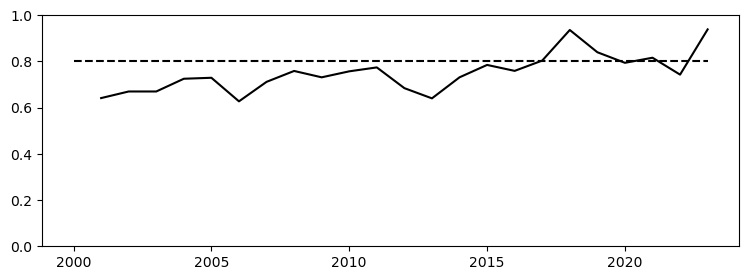

In [90]:
# plt.plot(df_tidy.Year, df_tidy.enrollment, 'k-')
plt.plot(df_tidy.Year, df_tidy.admissions/df_tidy.applicants, 'k-')
plt.plot([2000,2023], [0.8,0.8], 'k--')

ax = plt.gca()
ax.set_ylim([0,1])

fig = plt.gcf()
fig.set_size_inches(9,3)

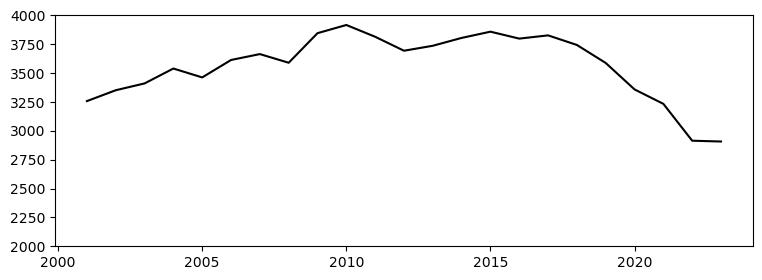

In [88]:
plt.plot(df_tidy.Year, df_tidy.enrollment, 'k-')
ax = plt.gca()
ax.set_ylim([2000,4000])
fig = plt.gcf()
fig.set_size_inches(9,3)